In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math

In [3]:
# esthetic definitions for the plots
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
#matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

aquí voy y todo bien 1
aquí voy y todo bien 1
aquí voy y todo bien 1.28753
aquí voy y todo bien 2.72755
aquí voy y todo bien 2.00754
aquí voy y todo bien 2.08076
aquí voy y todo bien 2.04415
aquí voy y todo bien 2.08008
aquí voy y todo bien 2.08042
aquí voy y todo bien 2.08008


in a next run with the same values of tau, you may decrease z_max_pk from  46000  to  45516.635522730474
grid size: 1022 2199 (2199, 1022)
> Plotting Theta_0
> Done
> Plotting phi
> Done


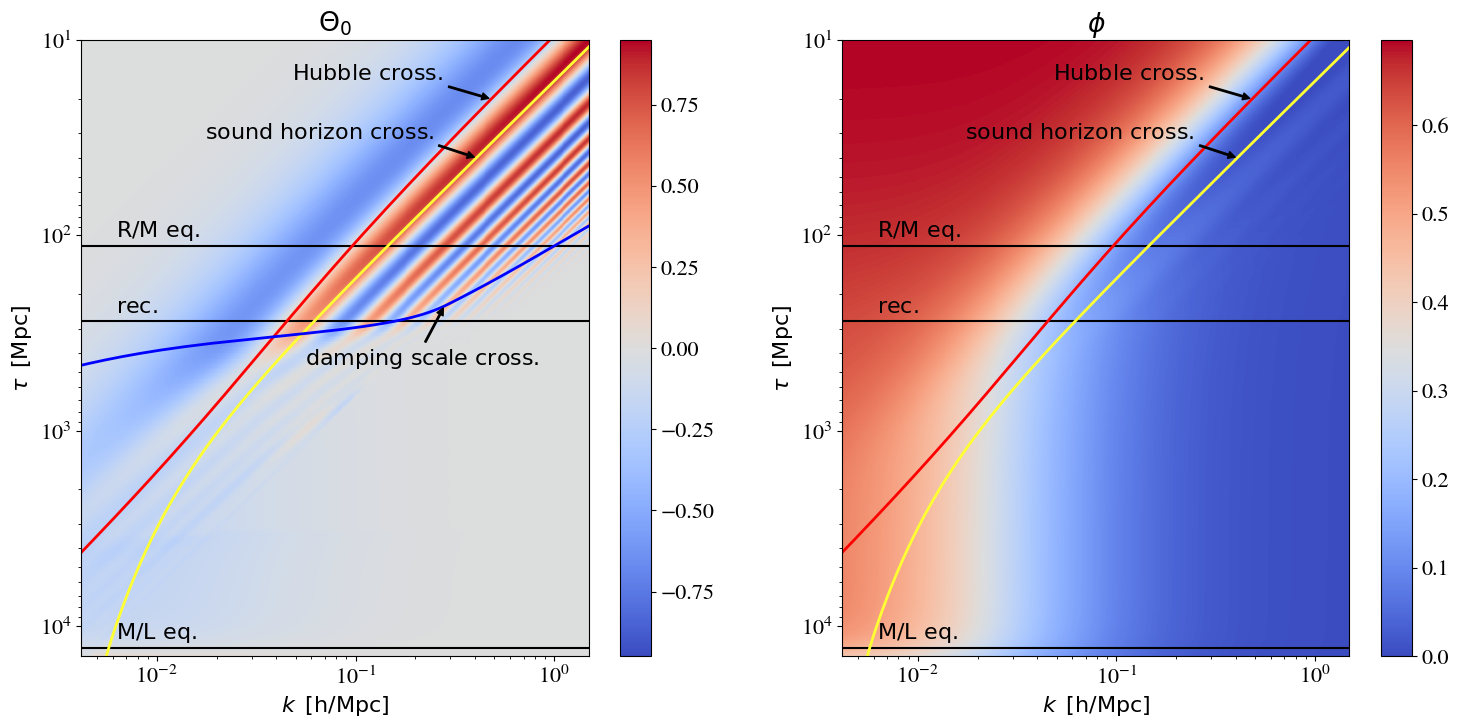

In [9]:
#############################################
#
# User settings controlling the figure aspect
#
z_max_pk = 46000       # highest redshift involved
k_per_decade = 400     # number of k values, controls final resolution
k_min_tau0 = 40.       # this value controls the minimum k value in the figure (it is k_min * tau0)
P_k_max_inv_Mpc =1.0   # this value is directly the maximum k value in the figure in Mpc
tau_num_early = 2000   # number of conformal time values before recombination, controls final resolution
tau_num_late = 200     # number of conformal time values after recombination, controls final resolution
tau_ini = 10.          # first value of conformal time in Mpc
tau_label_Hubble = 20. # value of time at which we want to place the label on Hubble crossing
tau_label_ks = 40.     # value of time at which we want to place the label on sound horizon crossing
tau_label_kd = 230.    # value of time at which we want to place the label on damping scale crossing
#
# Cosmological parameters and other CLASS parameters
#
common_settings = {# which output? transfer functions only
                   'output':'mTk',
                   # LambdaCDM parameters
                   'h':0.67556,
                   #'omega_b':0.022032,
                   #'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'n_s':0.9619,
                   'tau_reio':0.0925,
                    'Omega_fld' : 0,
                   'Omega_smg' : -1,
                   'Omega_Lambda': 0.69,
                   'Omega_b':0.02238280,
                   'Omega_cdm':0,
                   'gravity_model':'quintessence_monomial',
                   'x0_schm':1,
                   'theta_schm':2.7e-19,
                   'DM_schm':0.26,
                   'h_schm':1,
                   #'V0_schm':v_variable,
                   'lambda_schm':1,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
                   # other output and precision parameters
                   'z_max_pk':z_max_pk,
                   # to get a larger z_max in recfast, 
                   # we must increase both recfast_z_initial 
                   # and the number of sampled values recfast_Nz0
                   # (in order to keep the same stepzize asd in the default: Delta z = 0.5)
                   'recfast_Nz0':z_max_pk*2.,
                   'recfast_z_initial':z_max_pk+1.,
                   #'k_step_sub':'0.01',
                   'k_per_decade_for_pk':k_per_decade,
                   'k_per_decade_for_bao':k_per_decade,
                   'k_min_tau0':k_min_tau0, # this value controls the minimum k value in the figure
                   'perturb_sampling_stepsize':'0.05',
                   'P_k_max_1/Mpc':P_k_max_inv_Mpc,
                   'compute damping scale':'yes'} # needed to output and plot Silk damping scale
                  # 'gauge':'newtonian'}

###############
#   
# call CLASS 
#
###############
M = Class()
M.set(common_settings)
M.compute()
#
# define conformal time sampling array
#
times = M.get_current_derived_parameters(['tau_rec','conformal_age'])
tau_rec=times['tau_rec']
tau_0 = times['conformal_age']
tau1 = np.logspace(math.log10(tau_ini),math.log10(tau_rec),tau_num_early)
tau2 = np.logspace(math.log10(tau_rec),math.log10(tau_0),tau_num_late)[1:]
tau2[-1] *= 0.999 # this tiny shift avoids interpolation errors
tau = np.concatenate((tau1,tau2))
tau_num = len(tau)
#
# use table of background and thermodynamics quantitites to define some functions 
# returning some characteristic scales
# (of Hubble crossing, sound horizon crossing, etc.) at different time
#
background = M.get_background() # load background table
#print background.viewkeys()
thermodynamics = M.get_thermodynamics() # load thermodynamics table
#print thermodynamics.viewkeys()    
#
background_tau = background['conf. time [Mpc]'] # read conformal times in background table
background_z = background['z'] # read redshift
background_aH = 2.*math.pi*background['H [1/Mpc]']/(1.+background['z'])/M.h() # read 2pi * aH in [h/Mpc]
background_ks = 2.*math.pi/background['comov.snd.hrz.']/M.h() # read 2pi/(comoving sound horizon) in [h/Mpc]
background_rho_m_over_r =\
    (background['(.)rho_b']+background['(.)rho_smg'])\
    /(background['(.)rho_g']+background['(.)rho_ur']) # read rho_r / rho_m (to find time of equality)
background_rho_l_over_m =\
    background['(.)rho_lambda']\
    /(background['(.)rho_b']+background['(.)rho_smg']) # read rho_m / rho_lambda (to find time of equality)
thermodynamics_tau = thermodynamics['conf. time [Mpc]'] # read confromal times in thermodynamics table
thermodynamics_kd = 2.*math.pi/thermodynamics['r_d']/M.h() # read 2pi(comoving diffusion scale) in [h/Mpc]
#
# define a bunch of interpolation functions based on previous quantities
#
background_z_at_tau = interp1d(background_tau,background_z)
background_aH_at_tau = interp1d(background_tau,background_aH)
background_ks_at_tau = interp1d(background_tau,background_ks)
background_tau_at_mr = interp1d(background_rho_m_over_r,background_tau)
background_tau_at_lm = interp1d(background_rho_l_over_m,background_tau)
thermodynamics_kd_at_tau = interp1d(thermodynamics_tau, thermodynamics_kd)
#
# infer arrays of characteristic quantitites calculated at values of conformal time in tau array
#
aH = background_aH_at_tau(tau) 
ks = background_ks_at_tau(tau)
kd = thermodynamics_kd_at_tau(tau)
#
# infer times of R/M and M/Lambda equalities
#
tau_eq = background_tau_at_mr(1.)
tau_lambda = background_tau_at_lm(1.)
#
# check and inform user whether intiial arbitrary choice of z_max_pk was OK
max_z_needed = background_z_at_tau(tau[0])
if max_z_needed > z_max_pk:
    print('you must increase the value of z_max_pk to at least ',max_z_needed)
    () + 1  # this strange line is just a trick to stop the script execution there
else:
    print('in a next run with the same values of tau, you may decrease z_max_pk from ',z_max_pk,' to ',max_z_needed)
#
# get transfer functions at each time and build arrays Theta0(tau,k) and phi(tau,k)
#
for i in range(tau_num):
    one_time = M.get_transfer(background_z_at_tau(tau[i])) # transfer functions at each time tau
    if i ==0:   # if this is the first time in the loop: create the arrays (k, Theta0, phi)
        k = one_time['k (h/Mpc)']
        k_num = len(k)
        Theta0 = np.zeros((tau_num,k_num))
        phi = np.zeros((tau_num,k_num))
    Theta0[i,:] = 0.25*one_time['d_g'][:]
    phi[i,:] = one_time['phi'][:]
#
# find the global extra of Theta0(tau,k) and phi(tau,k), used to define color code later
#
Theta_amp = max(Theta0.max(),-Theta0.min()) 
phi_amp = max(phi.max(),-phi.min()) 
#
# reshaping of (k,tau) necessary to call the function 'pcolormesh'
#
K,T = np.meshgrid(k,tau)
#
# inform user of the size of the grids (related to the figure resolution)
#
print('grid size:',len(k),len(tau),Theta0.shape)
#
#################
#
# start plotting
#
#################
#
fig = plt.figure(figsize=(18,8)) 
#
# plot Theta0(k,tau)
#
ax_Theta = fig.add_subplot(121)
print('> Plotting Theta_0')
fig_Theta = ax_Theta.pcolormesh(K,T,Theta0,cmap='coolwarm',vmin=-Theta_amp, vmax=Theta_amp) #,shading='gouraud')
print('> Done')
#
# plot lines (characteristic times and scales)
#
ax_Theta.axhline(y=tau_rec,color='k',linestyle='-')
ax_Theta.axhline(y=tau_eq,color='k',linestyle='-')
ax_Theta.axhline(y=tau_lambda,color='k',linestyle='-')
ax_Theta.plot(aH,tau,'r-',linewidth=2)
ax_Theta.plot(ks,tau,color='#FFFF33',linestyle='-',linewidth=2)
ax_Theta.plot(kd,tau,'b-',linewidth=2)
#
# dealing with labels
#
ax_Theta.set_title(r'$\Theta_0$')
ax_Theta.text(1.5*k[0],0.9*tau_rec,r'$\mathrm{rec.}$')
ax_Theta.text(1.5*k[0],0.9*tau_eq,r'$\mathrm{R/M} \,\, \mathrm{eq.}$')
ax_Theta.text(1.5*k[0],0.9*tau_lambda,r'$\mathrm{M/L} \,\, \mathrm{eq.}$')
ax_Theta.annotate(r'$\mathrm{Hubble} \,\, \mathrm{cross.}$',
                  xy=(background_aH_at_tau(tau_label_Hubble),tau_label_Hubble),
                  xytext=(0.1*background_aH_at_tau(tau_label_Hubble),0.8*tau_label_Hubble),
                  arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))
ax_Theta.annotate(r'$\mathrm{sound} \,\, \mathrm{horizon} \,\, \mathrm{cross.}$',
                  xy=(background_ks_at_tau(tau_label_ks),tau_label_ks),
                  xytext=(0.07*background_aH_at_tau(tau_label_ks),0.8*tau_label_ks),
                  arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))
ax_Theta.annotate(r'$\mathrm{damping} \,\, \mathrm{scale} \,\, \mathrm{cross.}$',
                  xy=(thermodynamics_kd_at_tau(tau_label_kd),tau_label_kd),
                  xytext=(0.2*thermodynamics_kd_at_tau(tau_label_kd),2.0*tau_label_kd),
                  arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))
#
# dealing with axes
#
ax_Theta.set_xlim(k[0],k[-1])
ax_Theta.set_xscale('log')
ax_Theta.set_yscale('log')
ax_Theta.set_xlabel(r'$k  \,\,\, \mathrm{[h/Mpc]}$')
ax_Theta.set_ylabel(r'$\tau   \,\,\, \mathrm{[Mpc]}$')
ax_Theta.invert_yaxis()
#
# color legend
#
fig.colorbar(fig_Theta)
#
# plot phi(k,tau)
#
ax_phi = fig.add_subplot(122)
ax_phi.set_xlim(k[0],k[-1])
#ax_phi.pcolor(K,T,phi,cmap='coolwarm')
print('> Plotting phi')
fig_phi = ax_phi.pcolormesh(K,T,phi,cmap='coolwarm',vmin=-0., vmax=phi_amp)
print('> Done')
#
# plot lines (characteristic times and scales)
#
ax_phi.axhline(y=tau_rec,color='k',linestyle='-')
ax_phi.axhline(y=tau_eq,color='k',linestyle='-')
ax_phi.axhline(y=tau_lambda,color='k',linestyle='-')
ax_phi.plot(aH,tau,'r-',linewidth=2)
ax_phi.plot(ks,tau,color='#FFFF33',linestyle='-',linewidth=2)
#
# dealing with labels
#
ax_phi.set_title(r'$\phi$')
ax_phi.text(1.5*k[0],0.9*tau_rec,r'$\mathrm{rec.}$')
ax_phi.text(1.5*k[0],0.9*tau_eq,r'$\mathrm{R/M} \,\, \mathrm{eq.}$')
ax_phi.text(1.5*k[0],0.9*tau_lambda,r'$\mathrm{M/L} \,\, \mathrm{eq.}$')
ax_phi.annotate(r'$\mathrm{Hubble} \,\, \mathrm{cross.}$',
                  xy=(background_aH_at_tau(tau_label_Hubble),tau_label_Hubble),
                  xytext=(0.1*background_aH_at_tau(tau_label_Hubble),0.8*tau_label_Hubble),
                  arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))
ax_phi.annotate(r'$\mathrm{sound} \,\, \mathrm{horizon} \,\, \mathrm{cross.}$',
                  xy=(background_ks_at_tau(tau_label_ks),tau_label_ks),
                  xytext=(0.07*background_aH_at_tau(tau_label_ks),0.8*tau_label_ks),
                  arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))
#
# dealing with axes
#
ax_phi.set_xscale('log')
ax_phi.set_yscale('log')
ax_phi.set_xlabel(r'$k \,\,\, \mathrm{[h/Mpc]}$')
ax_phi.set_ylabel(r'$\tau \,\,\, \mathrm{[Mpc]}$')
ax_phi.invert_yaxis()
#
# color legend
#
fig.colorbar(fig_phi)
#
# produce the PDF
#
#plt.show()
#plt.savefig('many_times.png',dpi=300)

